In [1]:
columns = np.array([-0.13003472, -0.11134259, -0.09299345, -0.07497494, -0.05727537,
       -0.03988362, -0.02278919, -0.00598207,  0.02680775,  0.05855645,
        0.08932811,  0.11918107])
index = np.array([  9.,  29.,  49., 109.])
values = np.array([[0.29067656, 0.26138457, 0.22974922, 0.19108379, 0.17760947,
        0.16677144, 0.15315066, 0.14143386, 0.13586838, 0.15944844,
        0.20162891, 0.24849609],
       [0.18346787, 0.16677144, 0.15549402, 0.14846394, 0.13887081,
        0.13433055, 0.13140135, 0.13143797, 0.13476993, 0.1398228 ,
        0.15241836, 0.16896833],
       [0.17057939, 0.16223118, 0.1537365 , 0.14758518, 0.14158032,
        0.13960311, 0.13755267, 0.13458686, 0.14926947, 0.15197898,
        0.15922875, 0.16779666],
       [0.15556725, 0.15036792, 0.14692611, 0.14359415, 0.14136063,
        0.13927358, 0.13872435, 0.13929189, 0.15728815, 0.16045535,
        0.164245  , 0.17032309]])
X = pd.DataFrame(values, columns=columns, index=index)

# 波动率曲面拟合

## 第一步 拟合出ATM点

In [3]:
x_orig = np.repeat(X.columns.values,X.shape[0]).reshape(X.shape[1], X.shape[0]).T
y_orig = X.values

x_std = np.std(x_orig, axis=1, keepdims=True)
y_std = np.std(x_orig, axis=1, keepdims=True)
x = x_orig / x_std
y = y_orig  / y_std

boundry = 3
I1 = (x>=0) & (x<=boundry)
I2 = (x<=0) & (x>=-boundry)

In [4]:
def fit_function_1(X, A):
    I1 = (X>=0) & (X<=boundry)
    I2 = (X<=0) & (X>=-boundry)
    return A[:, 0:1] + A[:,1:2]*X + A[:, 2:3]*X**2*I1 + A[:,3:4]*X**2*I2

In [5]:
def gradient_descend(x, y, alpha=0.01, n=10000):
    m = x.shape[1]
    A = np.random.randn(4,4)
    costs = []
    for i in range(n):
        hypothesis = fit_function_1(x, A)
        loss = hypothesis - y
        cost = np.sum(loss ** 2) / (2 *x.shape[1])
        costs.append(cost)

        a1_grad = np.sum(loss, axis=1) / m
        a2_grad = np.sum(x*loss, axis=1) / m
        a3_grad = np.sum(x**2*loss*I1, axis=1) / m   
        a4_grad = np.sum(x**2*loss*I2, axis=1) / m   

        A[:, 0] -=  alpha * a1_grad
        A[:, 1] -=  alpha * a2_grad
        A[:, 2] -=  alpha * a3_grad
        A[:, 3] -=  alpha * a4_grad
    return A, costs

In [6]:
def gradient_descend_constrain(x, y, alpha=0.01, n=10000, theta=0.1):
    m = x.shape[1]
    A = np.random.randn(4,4)
    costs = []
    for i in range(n):
        hypothesis = fit_function_1(x, A)
        loss = hypothesis - y
        cost = np.sum(loss ** 2) / (2 *x.shape[1])
        costs.append(cost)
        
        a3, a4 = A[:, 2], A[:, 3] 

        a1_grad = np.sum(loss, axis=1) / m
        a2_grad = np.sum(x*loss, axis=1) / m
        a3_grad = np.sum(x**2*loss*I1, axis=1) / m  + theta*a3*(a3<0)
        a4_grad = np.sum(x**2*loss*I2, axis=1) / m  + theta*a4*(a4<0)

        A[:, 0] -=  alpha * a1_grad
        A[:, 1] -=  alpha * a2_grad
        A[:, 2] -=  alpha * a3_grad
        A[:, 3] -=  alpha * a4_grad
    return A, costs

In [7]:
A, costs = gradient_descend_constrain(x, y, n=2000, theta=10)

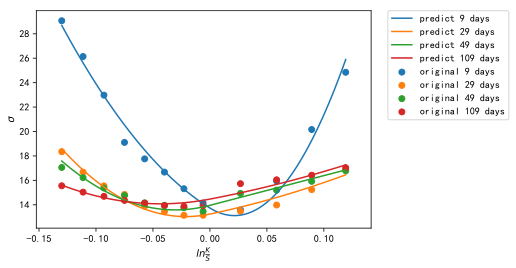

In [9]:
xx = np.linspace(x_orig.min(), x_orig.max(), 100)
for i in range(x.shape[0]):
    plt.scatter(x_orig[i], y_orig[i]*100,label='original '+ str(int(X.index[i]))+ ' days')
    plt.plot(xx , fit_function_1(xx/ x_std[i], A)[i]*y_std[i]*100, label='predict '+ str(int(X.index[i]))+ ' days')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel(r'$ln\frac{K}{S}$')
plt.ylabel(r'$\sigma$')

## 绘制波动率曲面

In [10]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

def make_surf(X,Y,Z):
    XX,YY = np.meshgrid(np.linspace(min(X),max(X),350),np.linspace(min(Y),max(Y),350))
    ZZ = griddata(np.array([X,Y]).T,np.array(Z),(XX,YY))
    return XX,YY,ZZ

In [11]:
x_3d = x_orig.reshape(-1)
y_3d = np.repeat(X.index.values, x.shape[1]).reshape((4,x.shape[1])).reshape(-1)
z_3d = (y_std * fit_function_1(x, A)).reshape(-1)

In [12]:
fig = plt.figure(figsize=(10,6))
ax = Axes3D(fig,  azim =-50,elev = 10)
ax.scatter3D(x_3d, y_3d, z_3d)

ax.plot_surface(*make_surf(x_3d, y_3d, z_3d))
#ax.plot_wireframe(*make_surf(x_3d, y_3d, z_3d))
plt.xlabel(r'$ln\frac{K}{S}$')
plt.ylabel('Expiry')
ax.set_zlabel('Implied Volatility')

### 无套利
- $\alpha_3>0, \alpha_4>0$
- 随着 `expiry` 增加 $ \left|\alpha_2 \right |, \alpha_3, \alpha_4$ 逐渐变小

## 第二步拟合

In [13]:
ATM = A[:, 0]
ATM

array([1.79221981, 1.72773455, 1.82084197, 1.88783007])

In [14]:
def fit_function_2(X, z1, z2, z3, z4):
    return z1 + (z2 + z3*X)*np.exp(-z4*X)

In [15]:
x = X.index.values
x = (x) / np.std(x)

y = ATM / np.std(ATM)

In [16]:
from scipy import optimize
par, par_var = optimize.curve_fit(fit_function_2, X.index.values, y)

C:\Users\J\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


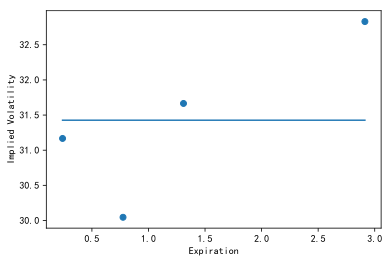

In [17]:
plt.scatter(x, y)
xx = np.linspace(x.min(), x.max(), 1000)
plt.plot(xx, fit_function_2(xx, *par))
plt.xlabel('Expiration')
plt.ylabel('Implied Volatility')